In [1]:
import pandas as pd
df = pd.read_csv('/Users/hwangjeonghyun/COVID-19-Machine-Learning/data/covid_preprocessed.csv')

In [2]:
df.head()

,SEX,PNEUMONIA,AGE,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,DEATH,PREGNANT_CLEAN
0,1,1,65,2,2,2,2,1,2,2,2,2,2,1,No
1,2,1,72,2,2,2,2,1,2,2,1,1,2,1,NotApplicable
2,2,2,55,1,2,2,2,2,2,2,2,2,2,1,NotApplicable
3,1,2,53,2,2,2,2,2,2,2,2,2,2,1,No
4,2,2,68,1,2,2,2,1,2,2,2,2,2,1,NotApplicable


In [3]:
# 범주형 변수 (문자형 + 숫자 코드형)
categorical_cols = [
    'SEX','PREGNANT_CLEAN',
    'PNEUMONIA','DIABETES','COPD','ASTHMA','INMSUPR',
    'HIPERTENSION','OTHER_DISEASE','CARDIOVASCULAR',
    'OBESITY','RENAL_CHRONIC','TOBACCO'
]

# 원-핫 인코딩 (PATIENT_TYPE은 인코딩에서 제외)
X = pd.get_dummies(df.drop(columns=['DEATH']), 
                   columns=categorical_cols, drop_first=False)

# 타깃
y = df['DEATH']

print("최종 Feature shape:", X.shape)
print("Feature 예시:", X.columns[:50].tolist())


최종 Feature shape: (1048575, 40)
Feature 예시: ['AGE', 'SEX_1', 'SEX_2', 'PREGNANT_CLEAN_No', 'PREGNANT_CLEAN_NotApplicable', 'PREGNANT_CLEAN_Unknown', 'PREGNANT_CLEAN_Yes', 'PNEUMONIA_1', 'PNEUMONIA_2', 'PNEUMONIA_99', 'DIABETES_1', 'DIABETES_2', 'DIABETES_Unknown', 'COPD_1', 'COPD_2', 'COPD_Unknown', 'ASTHMA_1', 'ASTHMA_2', 'ASTHMA_Unknown', 'INMSUPR_1', 'INMSUPR_2', 'INMSUPR_Unknown', 'HIPERTENSION_1', 'HIPERTENSION_2', 'HIPERTENSION_Unknown', 'OTHER_DISEASE_1', 'OTHER_DISEASE_2', 'OTHER_DISEASE_Unknown', 'CARDIOVASCULAR_1', 'CARDIOVASCULAR_2', 'CARDIOVASCULAR_Unknown', 'OBESITY_1', 'OBESITY_2', 'OBESITY_Unknown', 'RENAL_CHRONIC_1', 'RENAL_CHRONIC_2', 'RENAL_CHRONIC_Unknown', 'TOBACCO_1', 'TOBACCO_2', 'TOBACCO_Unknown']


In [ ]:
# 라이브러리, 기본 설정
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, precision_score, recall_score,
                             classification_report, confusion_matrix, average_precision_score)
from sklearn.utils import shuffle
from joblib import dump, load
import json, os

# 설정
GLOBAL_RS = 42
N_RUNS = 10   # 반복 횟수
ARTIFACT_DIR = "./modeling_artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)


In [ ]:
# 데이터 6:2:2 분할
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=GLOBAL_RS, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=GLOBAL_RS, stratify=y_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("사망 비율 — train:{:.4f}  val:{:.4f}  test:{:.4f}".format(
    np.mean(y_train), np.mean(y_val), np.mean(y_test)))


Train: (629145, 40) Val: (209715, 40) Test: (209715, 40)
사망 비율 — train:0.0734  val:0.0734  test:0.0734


In [12]:
# 하이퍼파라미터 탐색
base = LogisticRegression(
    solver='saga',
    max_iter=2000,   # 수렴 잘 되도록 살짝 늘림
    n_jobs=-1,
    class_weight='balanced',
    random_state=GLOBAL_RS,
    tol=1e-3         # 수렴 허용 오차 완화 → 속도 개선
)

param_grid = [
    {"penalty": ["l1", "l2"], "C": np.logspace(-2, 2, 6)},        # C 후보 6개
    {"penalty": ["elasticnet"], "C": np.logspace(-2, 2, 6), "l1_ratio": [0.5]}  # elasticnet 단순화
]

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=GLOBAL_RS)
grid = GridSearchCV(
    estimator=base,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

grid.fit(X_train, y_train)  # Train만 사용

best_params_fixed = grid.best_params_
best_cv_auc = grid.best_score_
print("Best params (fixed):", best_params_fixed)
print("CV AUC (Train CV):", best_cv_auc)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best params (fixed): {'C': np.float64(15.848931924611142), 'l1_ratio': 0.5, 'penalty': 'elasticnet'}
CV AUC (Train CV): 0.9196849823281977


In [14]:
# 고정된 HP로 10회 학습(시드만 변경) → Val에서 베스트 선택 + 체크포인트 저장
run_records = []
best_val_auc = -np.inf
best_run_idx = -1
best_model = None

for rseed in range(N_RUNS):
    print(f"\n=== Fixed-HP Run {rseed+1}/{N_RUNS} ===")

    # 시드별로 Train만 섞어 학습
    X_tr, y_tr = shuffle(X_train, y_train, random_state=rseed)

    model = LogisticRegression(
        **best_params_fixed,
        solver='saga',
        max_iter=2000,
        n_jobs=-1,
        class_weight='balanced',
        random_state=rseed   # 시드만 변경
    )
    model.fit(X_tr, y_tr)

    # 고정된 Val로 평가 (선택/기록용)
    val_prob = model.predict_proba(X_val)[:, 1]
    val_auc  = roc_auc_score(y_val, val_prob)
    val_pred05 = (val_prob >= 0.5).astype(int)

    rec = {
        "run": rseed,
        "val_auc": float(val_auc),
        "val_acc@0.5": float(accuracy_score(y_val, val_pred05)),
        "val_f1@0.5": float(f1_score(y_val, val_pred05)),
        "val_recall@0.5": float(recall_score(y_val, val_pred05)),
        "val_precision@0.5": float(precision_score(y_val, val_pred05))
    }
    run_records.append(rec)
    print(f"VAL AUC: {val_auc:.4f}")

    # 베스트 갱신 시 즉시 저장(체크포인트)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model = model
        best_run_idx = rseed

        dump(best_model, f"{ARTIFACT_DIR}/best_checkpoint_logistic.joblib")
        with open(f"{ARTIFACT_DIR}/checkpoint_meta_logistic.json", "w") as f:
            json.dump({
                "selected_run": int(best_run_idx),
                "best_val_auc": float(best_val_auc),
                "fixed_best_params": best_params_fixed
            }, f, ensure_ascii=False, indent=2)
        print(f"[Checkpoint saved] Run {best_run_idx}, VAL AUC={best_val_auc:.4f}")

top3 = sorted(run_records, key=lambda x: x["val_auc"], reverse=True)[:3]
print("\nTop runs by VAL AUC:\n", top3)



=== Fixed-HP Run 1/10 ===
VAL AUC: 0.9197
[Checkpoint saved] Run 0, VAL AUC=0.9197

=== Fixed-HP Run 2/10 ===
VAL AUC: 0.9197

=== Fixed-HP Run 3/10 ===
VAL AUC: 0.9197
[Checkpoint saved] Run 2, VAL AUC=0.9197

=== Fixed-HP Run 4/10 ===
VAL AUC: 0.9197

=== Fixed-HP Run 5/10 ===
VAL AUC: 0.9197
[Checkpoint saved] Run 4, VAL AUC=0.9197

=== Fixed-HP Run 6/10 ===
VAL AUC: 0.9197

=== Fixed-HP Run 7/10 ===
VAL AUC: 0.9197

=== Fixed-HP Run 8/10 ===
VAL AUC: 0.9197

=== Fixed-HP Run 9/10 ===
VAL AUC: 0.9197

=== Fixed-HP Run 10/10 ===
VAL AUC: 0.9197

Top runs by VAL AUC:
 [{'run': 4, 'val_auc': 0.9196755099626531, 'val_acc@0.5': 0.8617313973726247, 'val_f1@0.5': 0.47106036008099084, 'val_recall@0.5': 0.8390408733510949, 'val_precision@0.5': 0.3274497869750457}, {'run': 2, 'val_auc': 0.9196748266281792, 'val_acc@0.5': 0.8617313973726247, 'val_f1@0.5': 0.47106036008099084, 'val_recall@0.5': 0.8390408733510949, 'val_precision@0.5': 0.3274497869750457}, {'run': 5, 'val_auc': 0.91967469738483

In [15]:
# 임계값 최적화 (F1 기준, Val만 사용)
def find_best_threshold_by_f1(y_true, y_prob, grid=np.linspace(0.05, 0.95, 37)):
    best_f1, best_t = -1.0, 0.5
    for t in grid:
        pred = (y_prob >= t).astype(int)
        f1 = f1_score(y_true, pred)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t, best_f1

from sklearn.metrics import average_precision_score

val_prob_best = best_model.predict_proba(X_val)[:, 1]
best_thresh, best_val_f1 = find_best_threshold_by_f1(y_val, val_prob_best)
val_pr_auc = average_precision_score(y_val, val_prob_best)

print(f"Best threshold(F1): {best_thresh:.2f} | VAL F1: {best_val_f1:.4f} | VAL PR-AUC: {val_pr_auc:.4f}")


Best threshold(F1): 0.80 | VAL F1: 0.5392 | VAL PR-AUC: 0.4657


In [17]:
# Train+Val 재학습 → 최종 모델 확정
final_model = LogisticRegression(
    **best_params_fixed,
    solver='saga',
    max_iter=2000,
    n_jobs=-1,
    class_weight='balanced',
    random_state=0   # 최종 모델 재현성용 고정 시드
)
final_model.fit(
    np.vstack([X_train, X_val]),
    np.hstack([y_train, y_val])
)
print("Final model trained on Train+Val.")


Final model trained on Train+Val.


In [18]:
# Test 1회 평가 (0.5 & 최적 임계값 비교)
def evaluate_binary(y_true, y_prob, threshold=0.5, title=""):
    y_pred = (y_prob >= threshold).astype(int)
    auc = roc_auc_score(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n=== {title} ===")
    print(f"Threshold: {threshold:.2f}")
    print(f"ROC-AUC: {auc:.4f} | PR-AUC: {pr_auc:.4f}")
    print(f"ACC: {acc:.4f} | F1: {f1:.4f} | Recall: {rec:.4f} | Precision: {prec:.4f}")
    print("Confusion matrix [[TN FP],[FN TP]]:\n", cm)
    print(classification_report(y_true, y_pred, digits=4))

test_prob = final_model.predict_proba(X_test)[:, 1]
evaluate_binary(y_test, test_prob, threshold=0.5, title="Test @0.5")
evaluate_binary(y_test, test_prob, threshold=best_thresh, title="Test @optimal threshold (F1 from VAL)")


/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(



=== Test @0.5 ===
Threshold: 0.50
ROC-AUC: 0.9198 | PR-AUC: 0.4685
ACC: 0.8637 | F1: 0.4735 | Recall: 0.8353 | Precision: 0.3304
Confusion matrix [[TN FP],[FN TP]]:
 [[168278  26049]
 [  2535  12853]]
              precision    recall  f1-score   support

           0     0.9852    0.8660    0.9217    194327
           1     0.3304    0.8353    0.4735     15388

    accuracy                         0.8637    209715
   macro avg     0.6578    0.8506    0.6976    209715
weighted avg     0.9371    0.8637    0.8888    209715


=== Test @optimal threshold (F1 from VAL) ===
Threshold: 0.80
ROC-AUC: 0.9198 | PR-AUC: 0.4685
ACC: 0.9191 | F1: 0.5406 | Recall: 0.6487 | Precision: 0.4635
Confusion matrix [[TN FP],[FN TP]]:
 [[182771  11556]
 [  5406   9982]]
              precision    recall  f1-score   support

           0     0.9713    0.9405    0.9557    194327
           1     0.4635    0.6487    0.5406     15388

    accuracy                         0.9191    209715
   macro avg     0.7174

In [19]:
# 최종 저장 + 재로딩 검증(동일성 체크)
dump(final_model, f"{ARTIFACT_DIR}/best_logreg_FINAL_logistic.joblib")
with open(f"{ARTIFACT_DIR}/metadata_logistic.json", "w") as f:
    json.dump({
        "selected_run": int(best_run_idx),
        "best_val_auc": float(best_val_auc),
        "best_threshold(F1)": float(best_thresh),
        "fixed_best_params": best_params_fixed,
        "n_runs": int(N_RUNS),
        "run_records_top3": top3
    }, f, ensure_ascii=False, indent=2)

# 재로딩 검증
loaded = load(f"{ARTIFACT_DIR}/best_logreg_FINAL_logistic.joblib")
p1 = final_model.predict_proba(X_test)[:, 1]
p2 = loaded.predict_proba(X_test)[:, 1]
assert np.allclose(p1, p2), "Reloaded predictions differ!"
print("Reloaded predictions are identical")


Reloaded predictions are identical


/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/hwangjeonghyun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


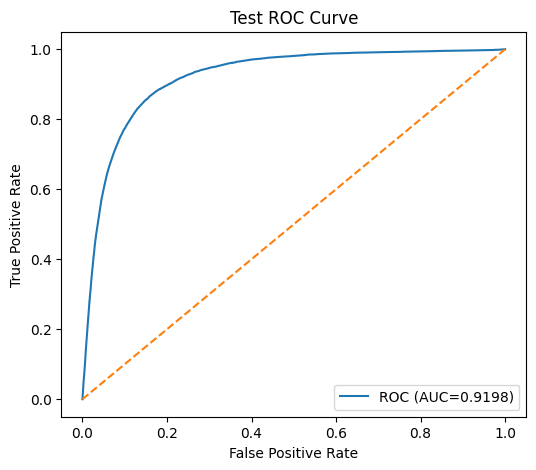

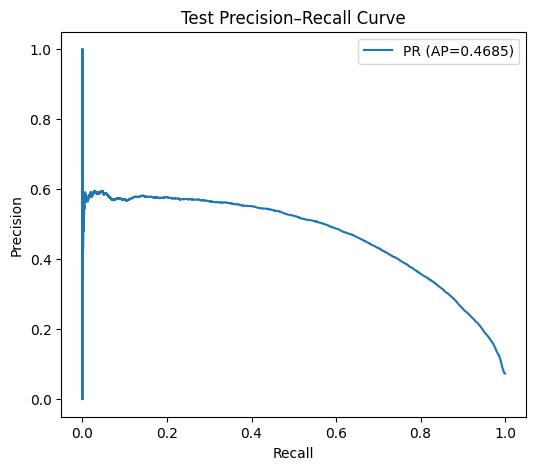

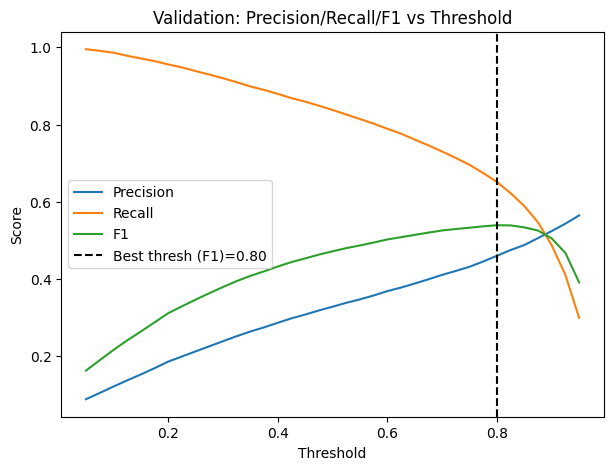

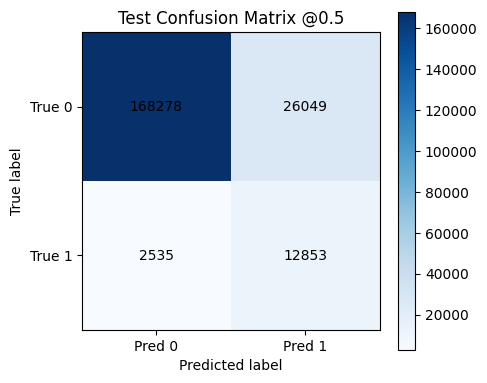

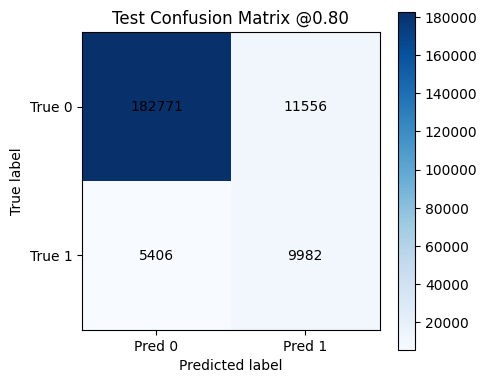

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, f1_score, precision_score, recall_score
import numpy as np

# 확률
val_prob_best = final_model.predict_proba(X_val)[:, 1]
test_prob = final_model.predict_proba(X_test)[:, 1]

# ---------------------------
# 1) ROC Curve (Test)
# ---------------------------
fpr, tpr, _ = roc_curve(y_test, test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.4f})")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test ROC Curve")
plt.legend()
plt.show()

# ---------------------------
# 2) Precision–Recall Curve (Test)
# ---------------------------
prec, rec, _ = precision_recall_curve(y_test, test_prob)
pr_auc = average_precision_score(y_test, test_prob)

plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"PR (AP={pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Test Precision–Recall Curve")
plt.legend()
plt.show()

# ---------------------------
# 3) Threshold vs Precision/Recall/F1 (Validation 기준)
# ---------------------------
def curve_threshold_metrics(y_true, y_prob, grid=np.linspace(0.05,0.95,37)):
    precs, recs, f1s = [], [], []
    for t in grid:
        y_pred = (y_prob >= t).astype(int)
        precs.append(precision_score(y_true, y_pred, zero_division=0))
        recs.append(recall_score(y_true, y_pred))
        f1s.append(f1_score(y_true, y_pred))
    return grid, precs, recs, f1s

ts, precs, recs, f1s = curve_threshold_metrics(y_val, val_prob_best)

plt.figure(figsize=(7,5))
plt.plot(ts, precs, label="Precision")
plt.plot(ts, recs,  label="Recall")
plt.plot(ts, f1s,   label="F1")
plt.axvline(best_thresh, linestyle="--", color="k", label=f"Best thresh (F1)={best_thresh:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Validation: Precision/Recall/F1 vs Threshold")
plt.legend()
plt.show()

# ---------------------------
# 4) Confusion Matrix (Test @0.5 vs @best_thresh)
# ---------------------------
def plot_cm(y_true, y_prob, thr, title):
    y_pred = (y_prob >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4.8,4.4))
    plt.imshow(cm, cmap="Blues")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Pred 0","Pred 1"])
    plt.yticks(tick_marks, ["True 0","True 1"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, format(cm[i, j], "d"),
                     ha="center", va="center", color="black")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

plot_cm(y_test, test_prob, 0.5, "Test Confusion Matrix @0.5")
plot_cm(y_test, test_prob, best_thresh, f"Test Confusion Matrix @{best_thresh:.2f}")
